<a href="https://colab.research.google.com/github/guidohc98/mi_repositorio/blob/master/arboles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árboles de Clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer

Usaremos el dataset de **Titanic**: https://www.kaggle.com/competitions/titanic/data

In [8]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Vemos la distribución del target

In [12]:
train["Survived"].value_counts(normalize=True)

,proportion
Survived,
0,0.616162
1,0.383838


Separamos train y validacion

In [13]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,
                                                  stratify=y)

In [15]:
y_train

,Survived
400,1
122,0
358,1
626,0
874,1
...,...
537,1
736,0
462,0
347,1


# Árboles en sklearn

Revisar la [documentacion](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [16]:
dt = DecisionTreeClassifier()

## Overfitting en árboles

Vamos a comenzar tomando unicamente los atributos originalmente numericos

In [17]:
numericos = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

In [ ]:
X_train[numericos].mean()

,0
Pclass,2.305152
Age,29.761363
SibSp,0.505945
Parch,0.384412
Fare,31.612147


In [ ]:
X_train[numericos].fillna(X_train[numericos].mean())

,Pclass,Age,SibSp,Parch,Fare
400,3,39.000000,0,0,7.9250
122,2,32.500000,1,0,30.0708
358,3,29.761363,0,0,7.8792
626,2,57.000000,0,0,12.3500
874,2,28.000000,1,0,24.0000
...,...,...,...,...,...
537,1,30.000000,0,0,106.4250
736,3,48.000000,1,3,34.3750
462,1,47.000000,0,0,38.5000
347,3,29.761363,1,0,16.1000


In [ ]:
depths = [*range(2,51,2)] # lista con profundidas a probar
train_acc = [] # lista vacia en donde vamos a ir metiendo las accuracy de train
valid_acc = [] # lista vacia en donde vamos a ir metiendo las accuracy de validacion

for depth in depths: # itero sobre los distintos niveles de profundidad
    dt = DecisionTreeClassifier(max_depth=depth) # ajusto el arbol indicando al profundidad maxima
    dt.fit(X_train[numericos].fillna(X_train[numericos].mean()), y_train) # ajusto modelo
    y_train_pred = dt.predict(X_train[numericos].fillna(X_train[numericos].mean())) # predigo train
    y_val_pred = dt.predict(X_val[numericos].fillna(X_train[numericos].mean())) # predigo val

    # obtengo las accuracy en train y val
    train_accuracy = accuracy_score(y_train_pred, y_train)
    val_accuracy = accuracy_score(y_val_pred, y_val)

    # las agrego a la lista
    train_acc.append(train_accuracy)
    valid_acc.append(val_accuracy)

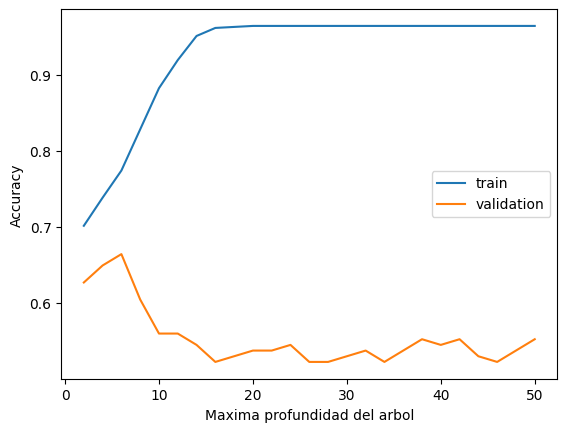

In [ ]:
plt.plot(depths, train_acc, label="train")
plt.plot(depths, valid_acc, label="validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Maxima profundidad del arbol")
plt.show()

In [ ]:
train_acc[-1]

0.964332892998679

In [ ]:
valid_acc[-1]

0.5522388059701493

In [ ]:
max_valid_acc = max(valid_acc)
max_valid_acc_index = valid_acc.index(max_valid_acc)
print(f"La maxima accuracy ({max_valid_acc:.2f}) en validacion se alcanza con max_depth={depths[max_valid_acc_index]}")

La maxima accuracy (0.66) en validacion se alcanza con max_depth=6


# Criterio: Entropia vs Gini

Podemos dejar fija la cantidad la profundidad de árbol y hacer variar el criterio de corte (information gain o gini gain)



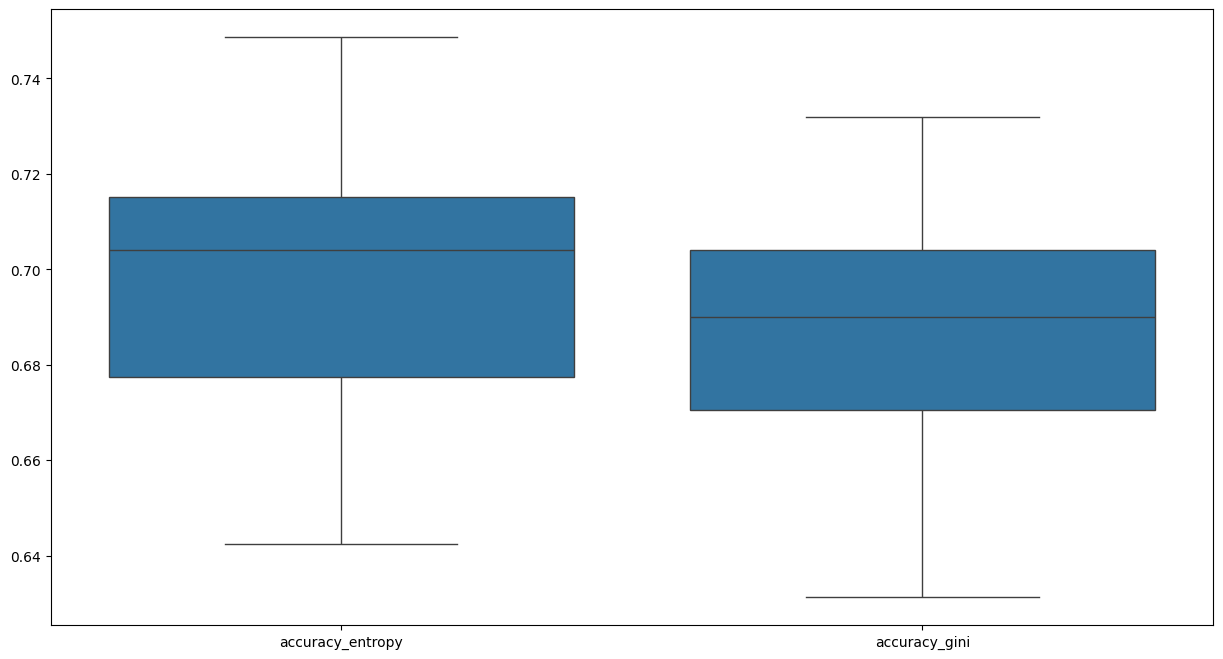

In [ ]:
n_seeds = 50
acc_scores = []

# TRAIN MODEL
for crit in ['entropy', 'gini']:
    for seed in range(n_seeds):

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
        dt = DecisionTreeClassifier(criterion=crit, max_depth=6)
        dt.fit(X_train[numericos].fillna(X_train[numericos].mean()), y_train)
        y_val_pred = dt.predict(X_val[numericos].fillna(X_val[numericos].mean()))
        acc_scores.append(accuracy_score(y_val, y_val_pred))

# PLOT RESULTS
plt.figure(figsize=(15,8))
labels = ["accuracy_entropy"] * n_seeds + ["accuracy_gini"] * n_seeds
sns.boxplot(x=labels, y=acc_scores);

In [ ]:
df_intermedio = pd.DataFrame({"labels": labels, "accuracy": acc_scores})

In [ ]:
df_intermedio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   labels    100 non-null    object 
 1   accuracy  100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


<Axes: xlabel='labels', ylabel='accuracy'>

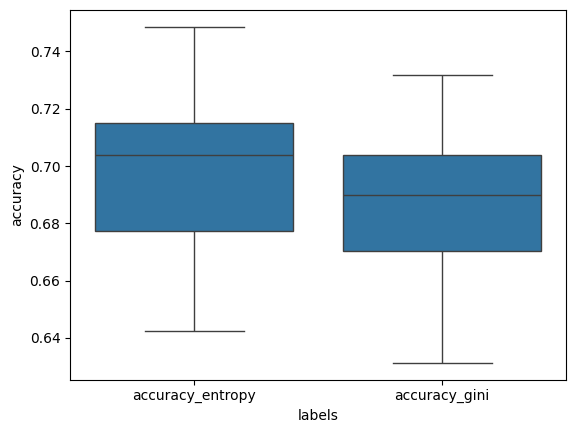

In [ ]:
sns.boxplot(y="accuracy", x="labels", data=df_intermedio)

In [ ]:
len(acc_scores)

100

In [ ]:
np.mean(acc_scores[:50])

np.float64(0.6970949720670392)

In [ ]:
np.mean(acc_scores[50:])

np.float64(0.6883798882681564)

# Todo junto: Búsqueda de hiperparámetros

Tanto la máxima profundidad como el criterio de ganancia son "hiper-párametros": le dan forma al modelo. Luego el algoritmo internamente encuentra los valores para los "parámetros" (qué atributo poner arriba, en qué valor partir en el caso de que sea un atributo continuo, etc.)


Emerge la cuestión: ¿Cómo elegimos hiperparámetros?

Podemos probar varias combinaciones y buscar el que mejor performe en validación. Dadas estas combinaciones hay 2 formas básicas de explorar en ese espacio:

* Grid Search (exhaustivo)
* Random Search (aleatorio)

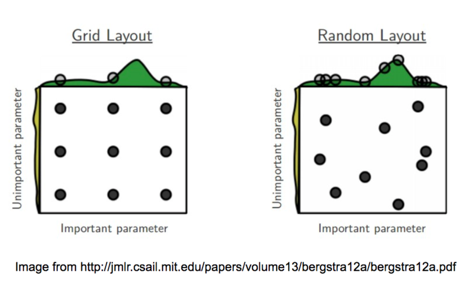

Vamos a realizar **GridSearch Cross Validation**

In [ ]:
params_grid = {'criterion': ['gini','entropy'],
               'max_depth': list(range(2,11))}

In [ ]:
params_grid

{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [ ]:
params_grid["max_depth"]

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# Diccionario con nombre de hiperparam como key, y posibles valores como value
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(2,11))}

# Particiona los datos en 5 para hacer el Cross Validation
kfoldcv = StratifiedKFold(n_splits=5)

# definimos al algoritmo de base, arbol de clasificaicon
dt = DecisionTreeClassifier()

# definimos la metrica de performance
scorer_acc = make_scorer(accuracy_score)

# Definimos el objeto grid search
grid_cv = GridSearchCV(estimator=dt, # pasamos el estimador
                        param_grid=params_grid, # pasamos la grilla de parametros
                        scoring=scorer_acc,  # definimos la metrica de performance "accuracy"
                        cv=kfoldcv) # la forma en la que hacemos el split

In [ ]:
# fiteamos sobre todo X e Y (son los datos de dsarrollo, internamente se hacen los splits)
grid_cv.fit(X[numericos].fillna(X[numericos].mean()), y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [ ]:
results = pd.DataFrame(grid_cv.cv_results_)

In [ ]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002649,0.000133,0.001921,0.000064,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.569832,0.685393,0.707865,0.741573,0.707865,0.682506,0.059125,12
1,0.002641,0.000033,0.001879,0.000014,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.631285,0.679775,0.707865,0.747191,0.758427,0.704909,0.046288,4
2,0.002765,0.000107,0.001849,0.000036,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.648045,0.685393,0.713483,0.747191,0.741573,0.707137,0.036865,3
3,0.003034,0.000342,0.002032,0.000252,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.648045,0.646067,0.730337,0.741573,0.747191,0.702643,0.045714,6
4,0.002996,0.000065,0.001860,0.000032,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.631285,0.646067,0.719101,0.634831,0.730337,0.672324,0.043204,15


In [ ]:
results[results["rank_test_score"]==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.003226,0.000086,0.002029,0.000226,entropy,7,"{'criterion': 'entropy', 'max_depth': 7}",0.648045,0.696629,0.730337,0.735955,0.752809,0.712755,0.037146,1


In [ ]:
grid_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [ ]:
mejor_arbol = grid_cv.best_estimator_

In [ ]:
test[numericos].fillna(X[numericos].mean())

,Pclass,Age,SibSp,Parch,Fare
0,3,34.500000,0,0,7.8292
1,3,47.000000,1,0,7.0000
2,2,62.000000,0,0,9.6875
3,3,27.000000,0,0,8.6625
4,3,22.000000,1,1,12.2875
...,...,...,...,...,...
413,3,29.699118,0,0,8.0500
414,1,39.000000,0,0,108.9000
415,3,38.500000,0,0,7.2500
416,3,29.699118,0,0,8.0500


In [ ]:
tenemos_que_predicir = test[numericos].fillna(X[numericos].mean())
predicciones = mejor_arbol.predict(tenemos_que_predicir)

In [ ]:
predicciones

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
test = test[["PassengerId"]]

In [ ]:
test

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [ ]:
type(test)

pandas.core.frame.DataFrame

In [ ]:
test["Survived"] = predicciones

In [ ]:
test.head(2)

,PassengerId,Survived
0,892,0
1,893,0


In [ ]:
test.to_csv("mejor_arbol_2025.csv", index=False)

## Graficar un árbol

In [ ]:
from sklearn.tree import plot_tree

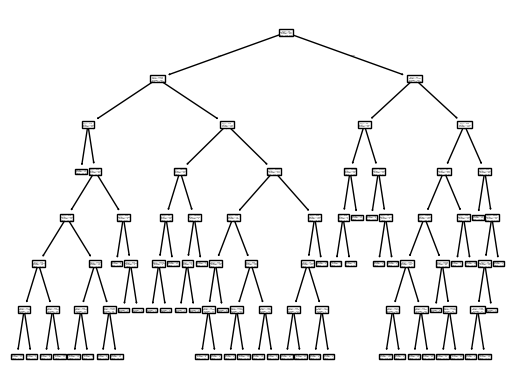

In [ ]:
plot_tree(mejor_arbol)
plt.savefig('mejor_arbol.png')
plt.show()

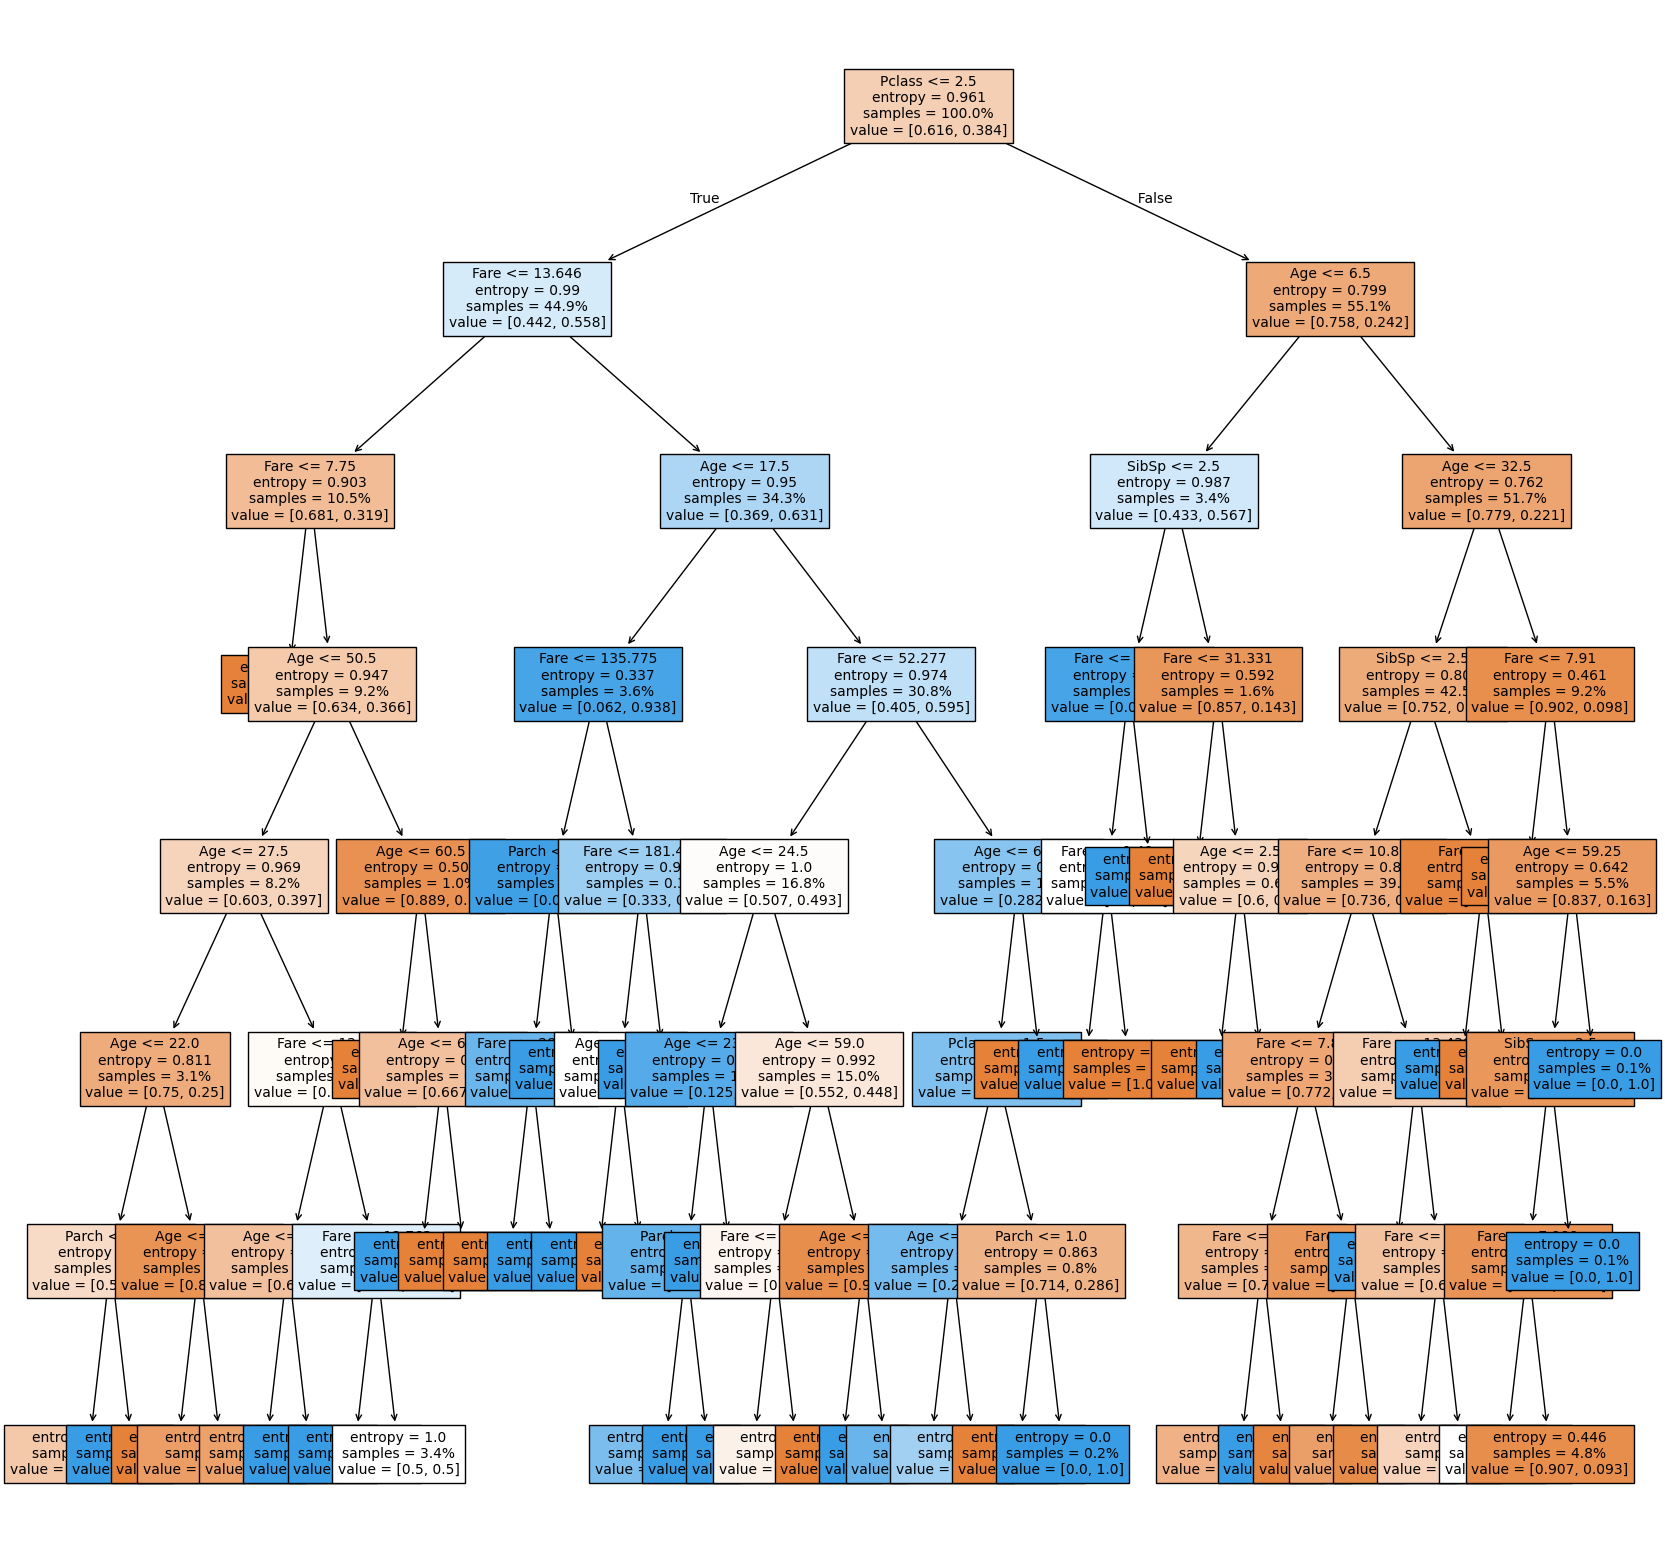

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(mejor_arbol, proportion=True,filled=True ,
          fontsize=10, feature_names=numericos)
plt.savefig('mejor_arbol_mejorado.png')
plt.show()

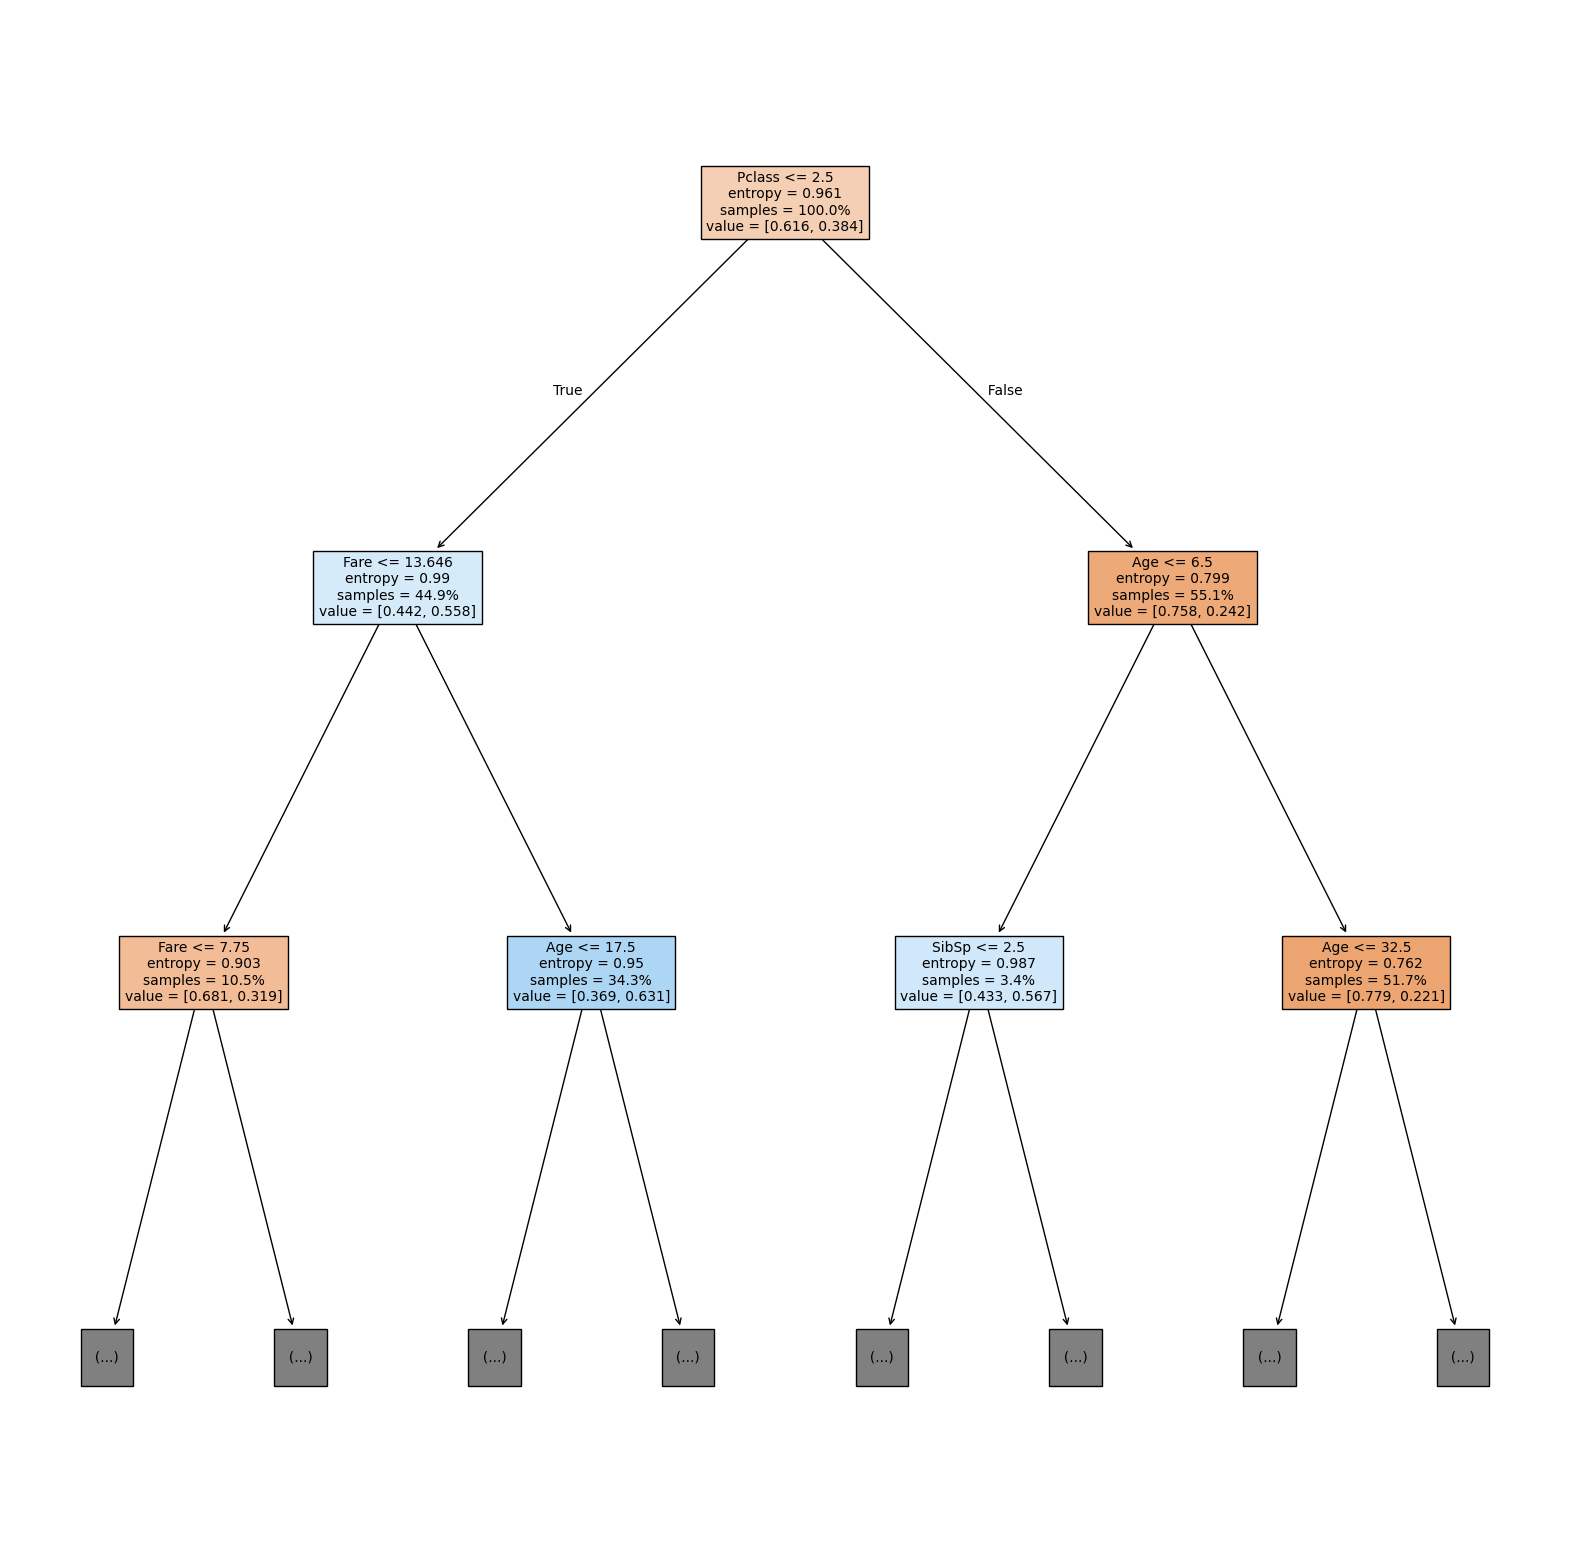

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(mejor_arbol, proportion=True,filled=True ,
          fontsize=10, feature_names=X[numericos].columns,
          max_depth=2)
plt.savefig('mejor_arbol_mejorado_recortado.png')
plt.show()

#### Extraer reglas del árbol

In [ ]:
from sklearn.tree import  export_text

tree_rules = export_text(mejor_arbol, feature_names=numericos)
print(tree_rules)

|--- Pclass <= 2.50
|   |--- Fare <= 13.65
|   |   |--- Fare <= 7.75
|   |   |   |--- class: 0
|   |   |--- Fare >  7.75
|   |   |   |--- Age <= 50.50
|   |   |   |   |--- Age <= 27.50
|   |   |   |   |   |--- Age <= 22.00
|   |   |   |   |   |   |--- Parch <= 1.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Parch >  1.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Age >  22.00
|   |   |   |   |   |   |--- Age <= 23.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Age >  23.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  27.50
|   |   |   |   |   |--- Fare <= 12.31
|   |   |   |   |   |   |--- Age <= 43.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Age >  43.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Fare >  12.31
|   |   |   |   |   |   |--- Fare <= 12.76
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Fare > 

# Guardar un modelo entrenado

In [ ]:
mejor_arbol

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [ ]:
import pickle


# guardar
with open('mejor_arbol.pkl','wb') as f:
    pickle.dump(mejor_arbol, f)

# abrir
with open('mejor_arbol.pkl', 'rb') as f:
    mejor_arbol_lectura = pickle.load(f)


In [ ]:
mejor_arbol_lectura.predict(test[numericos])

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,